Name : Shanmukeswara Reddy Medapati

Roll. No: AM.SC.P2AML25018

# Mental Stress Detection using SVM

In [1]:
# 1) Import libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve)
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 2) Load dataset
DATA_PATH = "/Users/shanmuk/Desktop/Amrita/Machine Learning/mental_stress_dataset.xlsx"  

df = pd.read_excel(DATA_PATH, index_col=0)  # index_col=0 because the file has 'id' index
print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (250, 9)
    sleep_hours  screen_time  work_hours  physical_activity  mood_level  \
id                                                                        
1           7.2          6.3         2.8                  8           5   
2           6.5          7.0        10.7                 17           6   
3           4.4         10.0        12.5                  2           4   
4           8.3          3.3         6.9                 65           5   
5           6.6          6.0         6.9                 20           7   

    caffeine_intake  age gender  stress_level  
id                                             
1                 2   56      M             0  
2                 1   46      F             1  
3                 3   32      F             1  
4                 0   60      F             0  
5                 1   25      M             1  


In [5]:
# 3) Quick exploratory checks
print("\nMissing values:\n", df.isna().sum())
print("\nTarget distribution (stress_level):\n", df['stress_level'].value_counts())


Missing values:
 sleep_hours          0
screen_time          0
work_hours           0
physical_activity    0
mood_level           0
caffeine_intake      0
age                  0
gender               0
stress_level         0
dtype: int64

Target distribution (stress_level):
 stress_level
1    163
0     87
Name: count, dtype: int64


In [7]:
# 4) Preprocessing 
# Convert categorical features (gender) -> numerical
df_processed = df.copy()
# Map gender to numeric
df_processed['gender'] = df_processed['gender'].map({'M': 0, 'F': 1})

# Features and target
feature_cols = ['sleep_hours', 'screen_time', 'work_hours', 'physical_activity',
                'mood_level', 'caffeine_intake', 'age', 'gender']
X = df_processed[feature_cols]
y = df_processed['stress_level']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Scale numeric features (important for SVM, k-NN, Logistic)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# 4) evaluation function
def evaluate_model(model, X_tr, X_te, y_tr, y_te, model_name="Model"):
    """
    Trains (if not already) and evaluates a sklearn model.
    Returns a dict of metrics and the predicted probabilities for ROC.
    """
    # Train model if it's not already fitted
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    # Some classifiers don't implement predict_proba (e.g., some SVC without probability=True)
    y_prob = None
    try:
        y_prob = model.predict_proba(X_te)[:, 1]
    except Exception:
        # try decision_function then sigmoid-like conversion if available
        try:
            dec = model.decision_function(X_te)
            # convert decision function to probability-like via sigmoid
            y_prob = 1 / (1 + np.exp(-dec))
        except Exception:
            # fallback: use predicted labels (not ideal for ROC)
            y_prob = y_pred

    metrics = {
        'model': model_name,
        'accuracy': accuracy_score(y_te, y_pred),
        'precision': precision_score(y_te, y_pred, zero_division=0),
        'recall': recall_score(y_te, y_pred),
        'f1': f1_score(y_te, y_pred),
        'roc_auc': roc_auc_score(y_te, y_prob)
    }
    cm = confusion_matrix(y_te, y_pred)
    return metrics, cm, y_pred, y_prob

In [11]:
#5) SVM with small GridSearch 
svc = SVC(kernel='rbf', probability=True, random_state=42)
param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 0.01, 0.1, 1]}
grid = GridSearchCV(svc, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid.fit(X_train_scaled, y_train)
print("Best params (SVM):", grid.best_params_)
best_svc = grid.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params (SVM): {'C': 10, 'gamma': 0.01}


In [13]:
# Evaluate SVM
svm_metrics, svm_cm, svm_pred, svm_prob = evaluate_model(best_svc, X_train_scaled, X_test_scaled, y_train, y_test, "SVM (RBF)")
print("\nSVM metrics:", svm_metrics)


SVM metrics: {'model': 'SVM (RBF)', 'accuracy': 0.78, 'precision': 0.775, 'recall': 0.9393939393939394, 'f1': 0.8493150684931506, 'roc_auc': 0.8716577540106952}


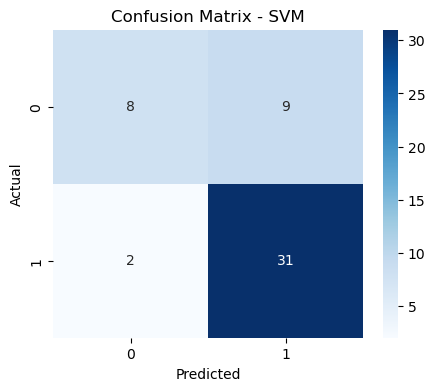

In [15]:
# Plot SVM confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

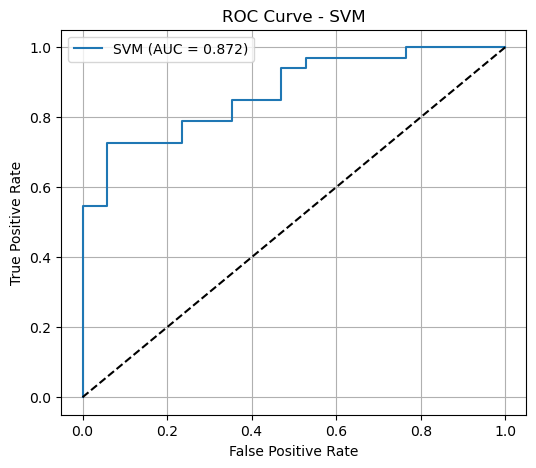

In [17]:
# Plot SVM ROC Curve
fpr_s, tpr_s, _ = roc_curve(y_test, svm_prob)
roc_auc_s = svm_metrics['roc_auc']
plt.figure(figsize=(6,5))
plt.plot(fpr_s, tpr_s, label=f'SVM (AUC = {roc_auc_s:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.title('ROC Curve - SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
#6) Additional Models Evaluation
# Define models with simple/default hyperparameters (quick to run). You can tune them if time permits.
models = [
    (LogisticRegression(max_iter=1000, random_state=42), "Logistic Regression"),
    (DecisionTreeClassifier(random_state=42), "Decision Tree"),
    (RandomForestClassifier(n_estimators=100, random_state=42), "Random Forest"),
    (KNeighborsClassifier(n_neighbors=5), "k-NN (k=5)"),
    (GradientBoostingClassifier(n_estimators=100, random_state=42), "Gradient Boosting")
]

results = []
cms = {}
probs_for_roc = {}

for mdl, name in models:
    # For models sensitive to scaling, use scaled features; Decision Tree & Random Forest can use original features (scaling doesn't harm)
    Xtr = X_train_scaled
    Xte = X_test_scaled
    metrics, cm, y_pred_model, y_prob_model = evaluate_model(mdl, Xtr, Xte, y_train, y_test, name)
    results.append(metrics)
    cms[name] = cm
    probs_for_roc[name] = y_prob_model
    print(f"\n{name} metrics:")
    print(pd.Series(metrics).drop('model'))
    print("Confusion Matrix:\n", cm)


Logistic Regression metrics:
accuracy         0.78
precision    0.823529
recall       0.848485
f1           0.835821
roc_auc       0.88057
dtype: object
Confusion Matrix:
 [[11  6]
 [ 5 28]]

Decision Tree metrics:
accuracy         0.62
precision    0.733333
recall       0.666667
f1           0.698413
roc_auc      0.598039
dtype: object
Confusion Matrix:
 [[ 9  8]
 [11 22]]

Random Forest metrics:
accuracy         0.76
precision    0.769231
recall       0.909091
f1           0.833333
roc_auc      0.809269
dtype: object
Confusion Matrix:
 [[ 8  9]
 [ 3 30]]

k-NN (k=5) metrics:
accuracy         0.68
precision     0.72973
recall       0.818182
f1           0.771429
roc_auc      0.690731
dtype: object
Confusion Matrix:
 [[ 7 10]
 [ 6 27]]

Gradient Boosting metrics:
accuracy         0.76
precision    0.818182
recall       0.818182
f1           0.818182
roc_auc      0.803922
dtype: object
Confusion Matrix:
 [[11  6]
 [ 6 27]]


In [21]:
# 7) Combine SVM results with others for comparison
# Add SVM metrics to results list as well
results.insert(0, svm_metrics)

# Create DataFrame for comparison
results_df = pd.DataFrame(results)
results_df = results_df[['model', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']]

# Sort by accuracy (best to worst)
results_df_sorted = results_df.sort_values(by='accuracy', ascending=False).reset_index(drop=True)

# Print the summary comparison table nicely
print("MODEL PERFORMANCE COMPARISON (SVM vs Others)")
print(results_df_sorted.to_string(index=False))

# Highlight SVM metrics separately
svm_row = results_df_sorted[results_df_sorted['model'].str.contains("SVM", case=False)].iloc[0]
print("\nBEST MODEL: SVM (RBF) PERFORMANCE ")
print(f"Accuracy : {svm_row['accuracy']*100:.2f}%")
print(f"Precision: {svm_row['precision']*100:.2f}%")
print(f"Recall   : {svm_row['recall']*100:.2f}%")
print(f"F1-score : {svm_row['f1']*100:.2f}%")
print(f"ROC-AUC  : {svm_row['roc_auc']*100:.2f}%")

MODEL PERFORMANCE COMPARISON (SVM vs Others)
              model  accuracy  precision   recall       f1  roc_auc
          SVM (RBF)      0.78   0.775000 0.939394 0.849315 0.871658
Logistic Regression      0.78   0.823529 0.848485 0.835821 0.880570
      Random Forest      0.76   0.769231 0.909091 0.833333 0.809269
  Gradient Boosting      0.76   0.818182 0.818182 0.818182 0.803922
         k-NN (k=5)      0.68   0.729730 0.818182 0.771429 0.690731
      Decision Tree      0.62   0.733333 0.666667 0.698413 0.598039

BEST MODEL: SVM (RBF) PERFORMANCE 
Accuracy : 78.00%
Precision: 77.50%
Recall   : 93.94%
F1-score : 84.93%
ROC-AUC  : 87.17%


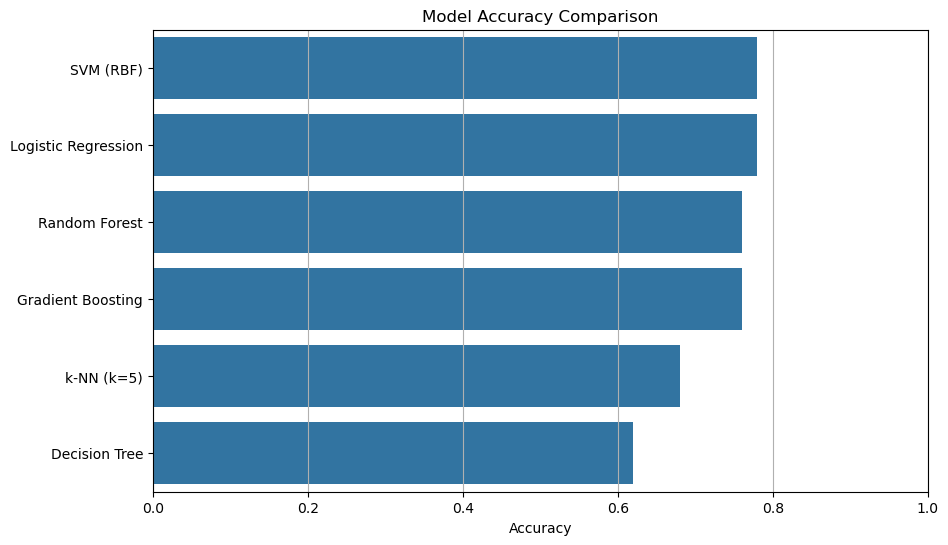

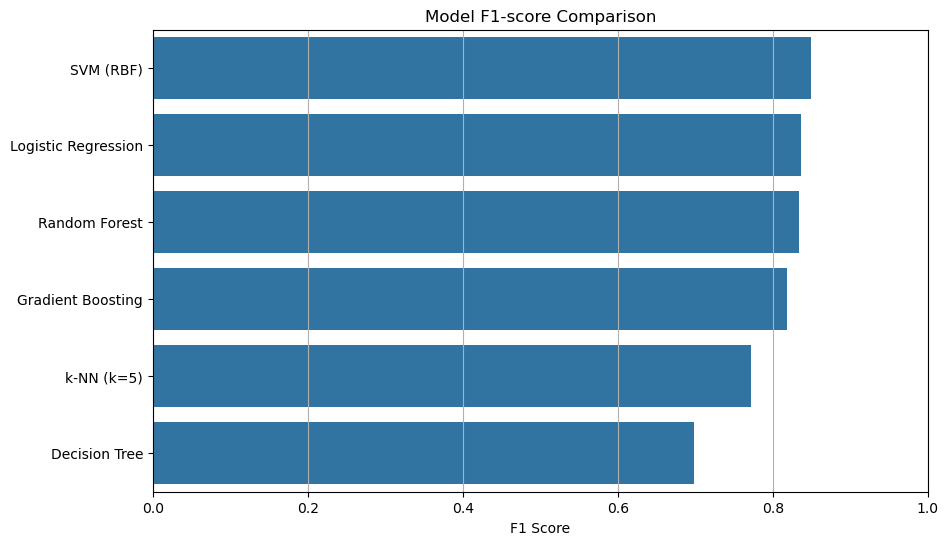

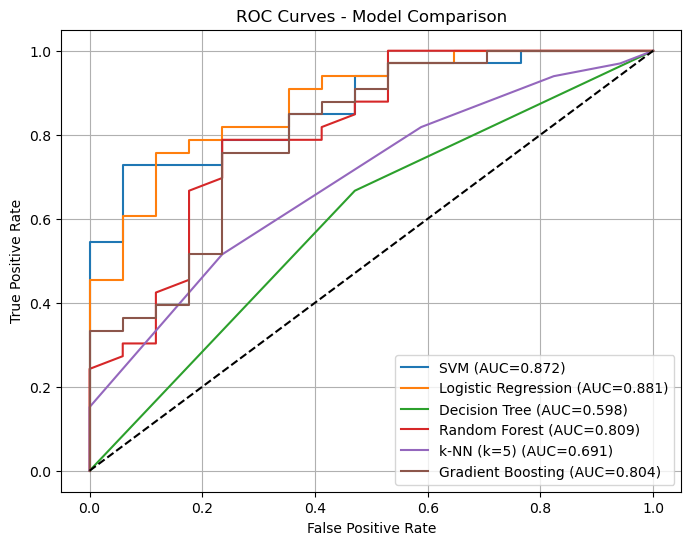

In [25]:
#8) Visual Comparison (Bar charts)
plt.figure(figsize=(10,6))
# Plot accuracies
sns.barplot(x='accuracy', y='model', data=results_df.sort_values(by='accuracy', ascending=False))
plt.title('Model Accuracy Comparison')
plt.xlim(0,1)
plt.xlabel('Accuracy')
plt.ylabel('')
plt.grid(axis='x')
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x='f1', y='model', data=results_df.sort_values(by='f1', ascending=False))
plt.title('Model F1-score Comparison')
plt.xlim(0,1)
plt.xlabel('F1 Score')
plt.ylabel('')
plt.grid(axis='x')
plt.show()

# ROC curves for all models on single plot
plt.figure(figsize=(8,6))
# SVM first
fpr, tpr, _ = roc_curve(y_test, svm_prob)
plt.plot(fpr, tpr, label=f"SVM (AUC={svm_metrics['roc_auc']:.3f})")

# other models
for r in results_df.itertuples():
    name = r.model
    if name == "SVM (RBF)":
        continue
    y_prob = probs_for_roc.get(name)
    # ensure y_prob exists
    try:
        fpr_m, tpr_m, _ = roc_curve(y_test, y_prob)
        auc_m = float(r.roc_auc)
        plt.plot(fpr_m, tpr_m, label=f"{name} (AUC={auc_m:.3f})")
    except Exception as e:
        # skip if ROC can't be computed
        print(f"Could not plot ROC for {name}: {e}")

plt.plot([0,1], [0,1], 'k--')
plt.title('ROC Curves - Model Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
#6) Additional Models Evaluation 
# -------------------------
# Define models with simple/default hyperparameters (quick to run). You can tune them if time permits.
models = [
    (LogisticRegression(max_iter=1000, random_state=42), "Logistic Regression"),
    (DecisionTreeClassifier(random_state=42), "Decision Tree"),
    (RandomForestClassifier(n_estimators=100, random_state=42), "Random Forest"),
    (KNeighborsClassifier(n_neighbors=5), "k-NN (k=5)"),
    (GradientBoostingClassifier(n_estimators=100, random_state=42), "Gradient Boosting")
]

results = []
cms = {}
probs_for_roc = {}

for mdl, name in models:
    # For models sensitive to scaling, use scaled features; Decision Tree & Random Forest can use original features (scaling doesn't harm)
    Xtr = X_train_scaled
    Xte = X_test_scaled
    metrics, cm, y_pred_model, y_prob_model = evaluate_model(mdl, Xtr, Xte, y_train, y_test, name)
    results.append(metrics)
    cms[name] = cm
    probs_for_roc[name] = y_prob_model
    print(f"\n{name} metrics:")
    print(pd.Series(metrics).drop('model'))
    print("Confusion Matrix:\n", cm)

In [27]:
#9) Print final classification reports (optional detail)
print("\n Detailed Classification Reports\n")
# SVM report
print("SVM Classification Report:\n", classification_report(y_test, svm_pred, zero_division=0))

for mdl_name, cm in cms.items():
    y_pred_names = None
    # Recompute predictions for reports (faster than storing earlier)
    # We have trained models; get predictions from them
    # We'll try to find them from the trained objects in the models list and SVM
    if mdl_name == "Decision Tree":
        model_obj = [m for m, n in models if n == "Decision Tree"][0]
    elif mdl_name == "Random Forest":
        model_obj = [m for m, n in models if n == "Random Forest"][0]
    elif mdl_name == "k-NN (k=5)":
        model_obj = [m for m, n in models if n == "k-NN (k=5)"][0]
    elif mdl_name == "Logistic Regression":
        model_obj = [m for m, n in models if n == "Logistic Regression"][0]
    elif mdl_name == "Gradient Boosting":
        model_obj = [m for m, n in models if n == "Gradient Boosting"][0]
    else:
        model_obj = None

    if model_obj is not None:
        y_pred_names = model_obj.predict(X_test_scaled)
        print(f"\n{mdl_name} Classification Report:\n", classification_report(y_test, y_pred_names, zero_division=0))


 Detailed Classification Reports

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.47      0.59        17
           1       0.78      0.94      0.85        33

    accuracy                           0.78        50
   macro avg       0.79      0.70      0.72        50
weighted avg       0.78      0.78      0.76        50


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.65      0.67        17
           1       0.82      0.85      0.84        33

    accuracy                           0.78        50
   macro avg       0.76      0.75      0.75        50
weighted avg       0.78      0.78      0.78        50


Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.53      0.49        17
           1       0.73      0.67      0.70        33

    accuracy                       

In [29]:
# 10) Save trained model and scaler (optional)
from joblib import dump
dump(best_svc, 'svm_stress_model.joblib')
dump(scaler, 'scaler.joblib')

# 11) Simple function to predict on a new sample
def predict_stress(sample_dict, model=best_svc, scaler_obj=scaler):
    """
    sample_dict example:
    {
     'sleep_hours': 6.0, 'screen_time': 5.0, 'work_hours': 8.0,
     'physical_activity': 20, 'mood_level': 5, 'caffeine_intake': 2,
     'age': 24, 'gender': 'M'
    }
    Returns predicted label (0/1) and probability for class 1.
    """
    s = sample_dict.copy()
    s['gender'] = 0 if s['gender'] in ['M', 'm', 0] else 1
    row = pd.DataFrame([s], columns=feature_cols)
    row_scaled = scaler_obj.transform(row)
    label = model.predict(row_scaled)[0]
    try:
        prob = model.predict_proba(row_scaled)[0,1]
    except Exception:
        dec = model.decision_function(row_scaled)
        prob = 1 / (1 + np.exp(-dec))
    return int(label), float(prob)

# Example usage of helper
example = {
    'sleep_hours': 5.5, 'screen_time': 7.0, 'work_hours': 9.0,
    'physical_activity': 10, 'mood_level': 4, 'caffeine_intake': 2,
    'age': 25, 'gender': 'F'
}
label, probability = predict_stress(example)
print("\nExample prediction -> Stress label:", label, "Probability:", round(probability,3))


Example prediction -> Stress label: 1 Probability: 0.858
